## Setup and Imports

First, let's set up our environment and import necessary modules:

In [7]:
import os
import sys
import numpy as np
import pprint
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Add the modcraft root directory to the Python path
# Adjust this if your notebook is not in the examples/StageWorkFlow directory
modcraft_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if modcraft_root not in sys.path:
    sys.path.append(modcraft_root)

# Check for src directory and add it if needed
src_dir = os.path.join(modcraft_root, "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import required modules
from stagecraft import Stage
from heptapod import model_init, gen_num

# Print paths to verify setup
print(f"ModCraft root: {modcraft_root}")
print(f"Source directory: {src_dir}")
print(f"Current working directory: {os.getcwd()}")

ModCraft root: /Users/akshayshanker/Research/Repos/modcraft
Source directory: /Users/akshayshanker/Research/Repos/modcraft/src
Current working directory: /Users/akshayshanker/Research/Repos/modcraft/examples/stage_workflow


## Helper Functions

We'll define some helper functions to make the model information more readable:

In [8]:
def print_section(title):
    """Print a section header to make output more readable."""
    display(Markdown(f"## {title}"))

def print_dict_summary(d, max_items=5, name="", indent=0):
    """Print a summarized view of a dictionary, skipping empty collections."""
    indent_str = " " * indent
    output_lines = []
    
    if not isinstance(d, dict):
        output_lines.append(f"{indent_str}{name}: {type(d).__name__}")
        print("\n".join(output_lines))
        return
        
    # Filter out empty collections first
    non_empty_items = {k: v for k, v in d.items() if not (isinstance(v, (dict, list, set)) and not v)}
    
    if not non_empty_items:
        output_lines.append(f"{indent_str}{name}: {{}} (contains only empty collections or is empty)")
        print("\n".join(output_lines))
        return
        
    output_lines.append(f"{indent_str}{name}:")
    items_shown_count = 0
    for key, value in non_empty_items.items():
        if items_shown_count >= max_items:
            output_lines.append(f"{indent_str}  ... ({len(non_empty_items) - max_items} more non-empty items)")
            break
            
        if isinstance(value, dict):
             # Recurse slightly for nested dicts if needed, or just show count
             output_lines.append(f"{indent_str}  {key}: (dict with {len(value)} items)")
        elif isinstance(value, list):
            output_lines.append(f"{indent_str}  {key}: (list with {len(value)} items)")
        elif isinstance(value, np.ndarray):
            output_lines.append(f"{indent_str}  {key}: (array with shape {value.shape} and dtype {value.dtype})")
        elif callable(value):
            output_lines.append(f"{indent_str}  {key}: (callable)")
        else:
            output_lines.append(f"{indent_str}  {key}: {type(value).__name__}")
            
        items_shown_count += 1
    
    print("\n".join(output_lines))


def print_model_summary(model, name="Model"):
    """Print a summary of a model's structure and contents."""
    output_lines = [f"### {name} Summary"]
    
    if model is None:
        output_lines.append("(Model is None)")
        display(Markdown("\n".join(output_lines)))
        return

    # Helper to safely get length or return 0
    def safe_len(obj):
        if hasattr(obj, '__len__'):
            return len(obj)
        return 0

    # Print basic information, checking attribute existence
    output_lines.append(f"**Parameters**: {safe_len(getattr(model, 'parameters', None))} items")
    output_lines.append(f"**Settings**: {safe_len(getattr(model, 'settings', None))} items")
    output_lines.append(f"**Methods**: {safe_len(getattr(model, 'methods', None))} items")
    
    # Print mathematical components
    math = getattr(model, 'math', None)
    if isinstance(math, dict) and math:
        output_lines.append("\n**Mathematical Components:**")
        display(Markdown("\n".join(output_lines)))
        print_dict_summary(math, name="  Math Dict", indent=2)
        output_lines = []
    
    # Print numerical components if available
    num = getattr(model, 'num', None)
    if isinstance(num, dict) and num:
        output_lines.append("\n**Numerical Components:**")
        display(Markdown("\n".join(output_lines)))
        print_dict_summary(num, name="  Num Dict", indent=2)
        output_lines = []
        
        # Example: Access specific numerical parts like state space grids
        state_space = num.get('state_space', {})
        if state_space:
             grid_lines = ["    Example Grid Info:"]
             for space_name, space_vars in state_space.items():
                  if isinstance(space_vars, dict):
                       for var_name, grid_array in space_vars.items():
                            if isinstance(grid_array, np.ndarray):
                                 grid_lines.append(f"      - {space_name}.{var_name}: {len(grid_array)} points [{grid_array[0]:.2f} to {grid_array[-1]:.2f}]")
             print("\n".join(grid_lines))
    
    # Print operator information for movers
    operator = getattr(model, 'operator', None)
    if isinstance(operator, dict) and operator:
        output_lines.append("\n**Operator:**")
        display(Markdown("\n".join(output_lines)))
        print_dict_summary(operator, name="  Details", indent=2)
    
    # Display any remaining lines
    if output_lines:
        display(Markdown("\n".join(output_lines)))

## 1. Model Initialization

The first step in working with a ModCraft model is initialization from a configuration file. This process:

1. Creates a Stage instance with initialization and numerical representation modules
2. Loads the configuration data
3. Generates symbolic models for the stage, perches, and movers

Let's initialize our Stage:

In [ ]:
# Get the path to the config file
script_dir = os.path.dirname(os.path.abspath(os.getcwd()))
config_file = os.path.join(script_dir, 'stage_workflow', 'example_config.yml')

# Step 1: Create a Stage with init_rep and num_rep
stage = Stage(name="ModOverview", init_rep=model_init, num_rep=gen_num)

# Step 2: Load the configuration file
print(f"Loading configuration from: {config_file}")
stage.load_config(config_file)

# Display basic information about the stage
print(f"\nStage name: {stage.name}")
print(f"Is portable: {stage.status_flags.get('portable', False)}")

print("\nStatus flags after initialization:")
print.print(stage.status_flags)

Loading configuration from: /Users/akshayshanker/Research/Repos/modcraft/examples/stage_workflow/example_config.yml

Stage name: ConsumptionSavingsIID
Is portable: False

Status flags after initialization:
{'all_movers_compiled': False,
 'all_movers_initialized': True,
 'all_perches_compiled': False,
 'all_perches_initialized': True,
 'compiled': False,
 'initialized': True,
 'portable': False,
 'simulated': False,
 'solvable': False,
 'solved': False}


### Understanding Status Flags

ModCraft uses a set of status flags to track the state of a model through its lifecycle:

- `initialized`: True after configuration has been loaded successfully
- `compiled`: True after numerical models have been generated
- `solvable`: True when the stage has both value functions and distributions set
- `solved`: True once the stage has been solved
- `portable`: True if the model can be easily serialized

These flags help maintain model integrity and guide the solution process.

## 2. Stage Model Overview (Initial)

Let's examine the structure of the initialized models before numerical compilation:

In [10]:
# Use the built-in method to see the full model structure
stage.print_model_structure()

Model structure saved to: stage_summary_ConsumptionSavingsIID.md
# Stage Summary: ConsumptionSavingsIID

## Stage Model
parameters:
  - beta: float
  - r: float
  - sigma: float
  - gamma: int
  - sigma_y: float
    ... (1 more non-empty items)
settings:
  - tol: float
  - max_iter: int
  - N_shock: int
  - n_grid_points: int
  - a_min: str
    ... (11 more non-empty items)
math:
  - functions: dict
  - constraints: dict
  - shocks: dict
  - state: dict

## Perches
### Perch: arvl
- sol: NoneType
- dist: NoneType
- model:
    parameters:
      - beta: float
      - r: float
      - sigma: float
      - gamma: int
      - sigma_y: float
        ... (1 more non-empty items)
    settings:
      - tol: float
      - max_iter: int
      - N_shock: int
      - n_grid_points: int
      - a_min: str
        ... (11 more non-empty items)
    math:
      - state: dict

### Perch: dcsn
- sol: NoneType
- dist: NoneType
- model:
    parameters:
      - beta: float
      - r: float
      - sigma: fl

'# Stage Summary: ConsumptionSavingsIID\n\n## Stage Model\nparameters:\n  - beta: float\n  - r: float\n  - sigma: float\n  - gamma: int\n  - sigma_y: float\n    ... (1 more non-empty items)\nsettings:\n  - tol: float\n  - max_iter: int\n  - N_shock: int\n  - n_grid_points: int\n  - a_min: str\n    ... (11 more non-empty items)\nmath:\n  - functions: dict\n  - constraints: dict\n  - shocks: dict\n  - state: dict\n\n## Perches\n### Perch: arvl\n- sol: NoneType\n- dist: NoneType\n- model:\n    parameters:\n      - beta: float\n      - r: float\n      - sigma: float\n      - gamma: int\n      - sigma_y: float\n        ... (1 more non-empty items)\n    settings:\n      - tol: float\n      - max_iter: int\n      - N_shock: int\n      - n_grid_points: int\n      - a_min: str\n        ... (11 more non-empty items)\n    math:\n      - state: dict\n\n### Perch: dcsn\n- sol: NoneType\n- dist: NoneType\n- model:\n    parameters:\n      - beta: float\n      - r: float\n      - sigma: float\n      -

### Analysis of the Model Structure

The model structure above shows the hierarchical organization of the ModCraft Stage:

- The Stage contains a main model with global parameters and settings
- Each Perch has its own model defining its state space and associated functions
- Movers connect perches through well-defined transformations

This modular design allows for clear separation of concerns, making it easier to understand, maintain, and extend complex economic models.

## 3. Individual Model Summaries (Initial)

Let's look at each model component in more detail:

In [11]:
# First, examine the Stage model
print_model_summary(stage.model, "Stage Model")

# Then examine each perch model
for perch_name in ["arvl", "dcsn", "cntn"]:
    perch = getattr(stage, perch_name)
    if perch: print_model_summary(perch.model, f"{perch_name.capitalize()} Perch Model")

# Finally, examine each mover model
movers_to_check = {"arvl_to_dcsn": stage.arvl_to_dcsn, 
                   "dcsn_to_cntn": stage.dcsn_to_cntn,
                   "cntn_to_arvl": stage.cntn_to_arvl, 
                   "dcsn_to_arvl": stage.dcsn_to_arvl, 
                   "cntn_to_dcsn": stage.cntn_to_dcsn}
                   
for mover_name, mover in movers_to_check.items():
    if mover: print_model_summary(mover.model, f"{mover_name} Mover Model")

### Stage Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 10 items

**Mathematical Components:**

    Math Dict:
    functions: (dict with 14 items)
    constraints: (dict with 2 items)
    shocks: (dict with 1 items)
    state: (dict with 3 items)


### Arvl Perch Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 0 items

**Mathematical Components:**

    Math Dict:
    state: (dict with 1 items)


### Dcsn Perch Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 0 items

**Mathematical Components:**

    Math Dict:
    state: (dict with 1 items)


### Cntn Perch Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 0 items

**Mathematical Components:**

    Math Dict:
    state: (dict with 1 items)


### arvl_to_dcsn Mover Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 10 items

**Mathematical Components:**

    Math Dict:
    functions: (dict with 1 items)
    constraints: (dict with 2 items)
    shocks: (dict with 1 items)
    state: (dict with 2 items)



**Operator:**

    Details:
    method: str



**Operator:**

### dcsn_to_cntn Mover Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 10 items

**Mathematical Components:**

    Math Dict:
    functions: (dict with 1 items)
    constraints: (dict with 2 items)
    state: (dict with 2 items)



**Operator:**

    Details:
    method: str
    objective: str



**Operator:**

### cntn_to_arvl Mover Model Summary
**Parameters**: 0 items
**Settings**: 0 items
**Methods**: 0 items

### dcsn_to_arvl Mover Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 10 items

**Mathematical Components:**

    Math Dict:
    functions: (dict with 1 items)
    constraints: (dict with 2 items)
    shocks: (dict with 1 items)
    state: (dict with 2 items)



**Operator:**

    Details:
    method: str



**Operator:**

### cntn_to_dcsn Mover Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 10 items

**Mathematical Components:**

    Math Dict:
    functions: (dict with 11 items)
    constraints: (dict with 2 items)
    state: (dict with 2 items)



**Operator:**

    Details:
    method: str



**Operator:**

### Key Observations on Model Components

From these model summaries, we can observe several important aspects of ModCraft's approach:

1. **Mathematical Representation**: Each model has a `math` dictionary containing symbolic representations of:
   - Functions (utility, production, etc.)
   - Constraints (budget constraints, resource limits, etc.)
   - Domains (state spaces, action spaces, etc.)

2. **Parameters and Settings**: Global model parameters are centralized in the Stage model, while component-specific settings are localized in the relevant submodels.

3. **Forward vs. Backward Movers**: 
   - Forward movers (`arvl_to_dcsn`, `dcsn_to_cntn`) implement the model mechanics
   - Backward movers (`cntn_to_dcsn`, `dcsn_to_arvl`) implement the solution algorithm

This separation allows economists to focus on model specification while solution algorithms can be swapped out or customized independently.

## 4. Numerical Compilation

Next, we'll compile the symbolic models into numerical representations that can be used for computation:

In [12]:
# Build the computational model using num_rep provided at init
success = stage.build_computational_model()
print(f"Compilation successful: {success}")
print("\nStatus flags after compilation:")
pprint.pprint(stage.status_flags)

Compilation successful: True

Status flags after compilation:
{'all_movers_compiled': True,
 'all_movers_initialized': True,
 'all_perches_compiled': True,
 'all_perches_initialized': True,
 'compiled': True,
 'initialized': True,
 'portable': False,
 'simulated': False,
 'solvable': False,
 'solved': False}


### What Happens During Compilation?

The numerical compilation step is a crucial transformation in ModCraft. During this process:

1. Symbolic mathematical expressions are converted to computational functions
2. State spaces are discretized into grids
3. Continuous functions are approximated for numerical computation
4. Memory is allocated for solution arrays

This step bridges the gap between the mathematical specification and the computational implementation, making the model ready for solving.

## 5. Compiled Model Structure

Let's examine the models after compilation to see what has changed:

In [13]:
# First, get an overview of the compiled stage structure
stage.print_model_structure()

Model structure saved to: stage_summary_ConsumptionSavingsIID.md
# Stage Summary: ConsumptionSavingsIID

## Stage Model
parameters:
  - beta: float
  - r: float
  - sigma: float
  - gamma: int
  - sigma_y: float
    ... (1 more non-empty items)
settings:
  - tol: float
  - max_iter: int
  - N_shock: int
  - n_grid_points: int
  - a_min: str
    ... (11 more non-empty items)
math:
  - functions: dict
  - constraints: dict
  - shocks: dict
  - state: dict
num:
  - functions: dict
  - constraints: dict
  - state_space: dict
  - shocks: dict
  - arvl: dict
    ... (2 more non-empty items)

## Perches
### Perch: arvl
- sol: NoneType
- dist: NoneType
- model:
    parameters:
      - beta: float
      - r: float
      - sigma: float
      - gamma: int
      - sigma_y: float
        ... (1 more non-empty items)
    settings:
      - tol: float
      - max_iter: int
      - N_shock: int
      - n_grid_points: int
      - a_min: str
        ... (11 more non-empty items)
    math:
      - state: 

'# Stage Summary: ConsumptionSavingsIID\n\n## Stage Model\nparameters:\n  - beta: float\n  - r: float\n  - sigma: float\n  - gamma: int\n  - sigma_y: float\n    ... (1 more non-empty items)\nsettings:\n  - tol: float\n  - max_iter: int\n  - N_shock: int\n  - n_grid_points: int\n  - a_min: str\n    ... (11 more non-empty items)\nmath:\n  - functions: dict\n  - constraints: dict\n  - shocks: dict\n  - state: dict\nnum:\n  - functions: dict\n  - constraints: dict\n  - state_space: dict\n  - shocks: dict\n  - arvl: dict\n    ... (2 more non-empty items)\n\n## Perches\n### Perch: arvl\n- sol: NoneType\n- dist: NoneType\n- model:\n    parameters:\n      - beta: float\n      - r: float\n      - sigma: float\n      - gamma: int\n      - sigma_y: float\n        ... (1 more non-empty items)\n    settings:\n      - tol: float\n      - max_iter: int\n      - N_shock: int\n      - n_grid_points: int\n      - a_min: str\n        ... (11 more non-empty items)\n    math:\n      - state: dict\n    num:

In [14]:
# Then examine each compiled model in detail
print_model_summary(stage.model, "Compiled Stage Model")

for perch_name in ["arvl", "dcsn", "cntn"]:
    perch = getattr(stage, perch_name)
    if perch: print_model_summary(perch.model, f"Compiled {perch_name.capitalize()} Perch Model")
        
for mover_name, mover in movers_to_check.items():
     if mover: print_model_summary(mover.model, f"Compiled {mover_name} Mover Model")

### Compiled Stage Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 10 items

**Mathematical Components:**

    Math Dict:
    functions: (dict with 14 items)
    constraints: (dict with 2 items)
    shocks: (dict with 1 items)
    state: (dict with 3 items)



**Numerical Components:**

    Num Dict:
    functions: (dict with 14 items)
    constraints: (dict with 2 items)
    state_space: (dict with 3 items)
    shocks: (dict with 1 items)
    arvl: (dict with 1 items)
    ... (2 more non-empty items)
    Example Grid Info:
      - arvl.a: 4000 points [0.01 to 10.00]
      - dcsn.m: 4000 points [0.00 to 5.00]
      - cntn.a_nxt: 4000 points [0.01 to 10.00]


### Compiled Arvl Perch Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 0 items

**Mathematical Components:**

    Math Dict:
    state: (dict with 1 items)



**Numerical Components:**

    Num Dict:
    state_space: (dict with 1 items)
    arvl: (dict with 1 items)
    Example Grid Info:
      - arvl.a: 4000 points [0.01 to 10.00]


### Compiled Dcsn Perch Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 0 items

**Mathematical Components:**

    Math Dict:
    state: (dict with 1 items)



**Numerical Components:**

    Num Dict:
    state_space: (dict with 1 items)
    dcsn: (dict with 1 items)
    Example Grid Info:
      - dcsn.m: 4000 points [0.00 to 5.00]


### Compiled Cntn Perch Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 0 items

**Mathematical Components:**

    Math Dict:
    state: (dict with 1 items)



**Numerical Components:**

    Num Dict:
    state_space: (dict with 1 items)
    cntn: (dict with 1 items)
    Example Grid Info:
      - cntn.a_nxt: 4000 points [0.01 to 10.00]


### Compiled arvl_to_dcsn Mover Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 10 items

**Mathematical Components:**

    Math Dict:
    functions: (dict with 1 items)
    constraints: (dict with 2 items)
    shocks: (dict with 1 items)
    state: (dict with 2 items)



**Numerical Components:**

    Num Dict:
    functions: (dict with 1 items)
    constraints: (dict with 2 items)
    state_space: (dict with 2 items)
    shocks: (dict with 1 items)
    arvl: (dict with 1 items)
    ... (1 more non-empty items)
    Example Grid Info:
      - arvl.a: 4000 points [0.01 to 10.00]
      - dcsn.m: 4000 points [0.00 to 5.00]



**Operator:**

    Details:
    method: str



**Operator:**

### Compiled dcsn_to_cntn Mover Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 10 items

**Mathematical Components:**

    Math Dict:
    functions: (dict with 1 items)
    constraints: (dict with 2 items)
    state: (dict with 2 items)



**Numerical Components:**

    Num Dict:
    functions: (dict with 1 items)
    constraints: (dict with 2 items)
    state_space: (dict with 2 items)
    dcsn: (dict with 1 items)
    cntn: (dict with 1 items)
    Example Grid Info:
      - dcsn.m: 4000 points [0.00 to 5.00]
      - cntn.a_nxt: 4000 points [0.01 to 10.00]



**Operator:**

    Details:
    method: str
    objective: str



**Operator:**

### Compiled cntn_to_arvl Mover Model Summary
**Parameters**: 0 items
**Settings**: 0 items
**Methods**: 0 items

### Compiled dcsn_to_arvl Mover Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 10 items

**Mathematical Components:**

    Math Dict:
    functions: (dict with 1 items)
    constraints: (dict with 2 items)
    shocks: (dict with 1 items)
    state: (dict with 2 items)



**Numerical Components:**

    Num Dict:
    functions: (dict with 1 items)
    constraints: (dict with 2 items)
    state_space: (dict with 2 items)
    shocks: (dict with 1 items)
    dcsn: (dict with 1 items)
    ... (1 more non-empty items)
    Example Grid Info:
      - dcsn.m: 4000 points [0.00 to 5.00]
      - arvl.a: 4000 points [0.01 to 10.00]



**Operator:**

    Details:
    method: str



**Operator:**

### Compiled cntn_to_dcsn Mover Model Summary
**Parameters**: 6 items
**Settings**: 16 items
**Methods**: 10 items

**Mathematical Components:**

    Math Dict:
    functions: (dict with 11 items)
    constraints: (dict with 2 items)
    state: (dict with 2 items)



**Numerical Components:**

    Num Dict:
    functions: (dict with 11 items)
    constraints: (dict with 2 items)
    state_space: (dict with 2 items)
    cntn: (dict with 1 items)
    dcsn: (dict with 1 items)
    Example Grid Info:
      - cntn.a_nxt: 4000 points [0.01 to 10.00]
      - dcsn.m: 4000 points [0.00 to 5.00]



**Operator:**

    Details:
    method: str



**Operator:**

### Key Differences After Compilation

Notice the important additions after compilation:

1. **Numerical Components**: Each model now has a `num` dictionary containing:
   - Discretized state grids
   - Computational functions
   - Interpolation objects
   - Optimization routines

2. **Status Flag Changes**: The `compiled` flag is now True

3. **Grid Information**: State spaces are now represented as numerical arrays with defined bounds and resolution

These numerical representations maintain the same structure as the mathematical models, but are now ready for computation.

## 6. Access Examples

Let's explore how to access different parts of the compiled model:

In [15]:
# Example 1: Access stage parameters
print("Stage parameters access:")
if hasattr(stage.model, 'parameters') and stage.model.parameters:
    for param_name in ["beta", "gamma", "r"]:
        if param_name in stage.model.parameters:
            print(f"  {param_name} = {stage.model.parameters[param_name]}")
else:
     print("  No parameters found in stage model.")

Stage parameters access:
  beta = 0.9
  gamma = 2
  r = 1.04


In [16]:
# Example 2: Access state space grids
print("State space grids access:")
if hasattr(stage.model, 'num') and stage.model.num:
    state_space = stage.model.num.get('state_space', {})
    if state_space:
        for perch_name, grids in state_space.items():
            print(f"  {perch_name} grids:")
            grid_data = []
            for grid_name, grid in grids.get('grids', {}).items():
                if isinstance(grid, np.ndarray):
                    grid_data.append((grid_name, grid))
                    print(f"    {grid_name}: {len(grid)} points - Range: [{grid[0]:.2f}, {grid[-1]:.2f}]")
            
            # Visualize the first grid we find as an example
            if grid_data:
                name, grid = grid_data[0]
                plt.figure(figsize=(10, 4))
                plt.plot(grid, np.zeros_like(grid), 'o', markersize=5)
                plt.title(f"{perch_name}.{name} Grid Points")
                plt.xlabel(f"{name} value")
                plt.grid(True)
                plt.show()

State space grids access:
  arvl grids:
  dcsn grids:
  cntn grids:


Setting perch data example:
Stage is solvable: True
cntn.sol is set: True
arvl.dist is set: True

Perch data access:
cntn.sol type: <class 'dict'>
  vlu_cntn: array shape (3,), first value 1.0
  lambda_cntn: array shape (3,), first value 0.1
arvl.dist type: <class 'numpy.ndarray'>
  distribution shape: (3,)


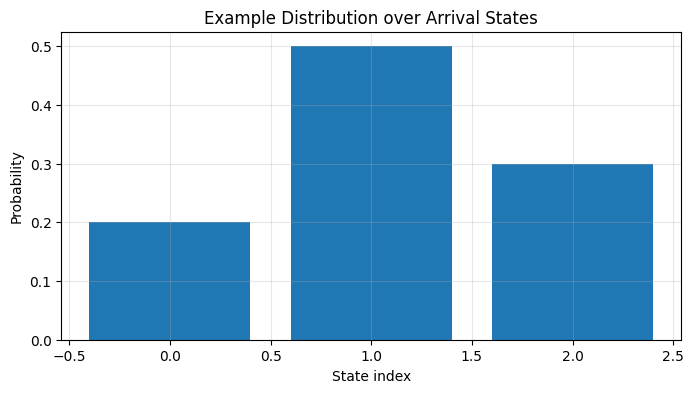

In [17]:
# Example 3: Setting and accessing perch data
print("Setting perch data example:")

# Set some example data for demonstration
cntn_sol_data = {"vlu_cntn": np.array([1.0, 2.0, 3.0]), "lambda_cntn": np.array([0.1, 0.2, 0.3])}
arvl_dist_data = np.array([0.2, 0.5, 0.3])  # Some distribution over states

# Set data to perches
stage.perches["cntn"].sol = cntn_sol_data  # Setting cntn.sol (formerly cntn.up)
stage.perches["arvl"].dist = arvl_dist_data  # Setting arvl.dist (formerly arvl.down)

# Check if the stage is now solvable
stage._check_solvability()
print(f"Stage is solvable: {stage.status_flags['solvable']}")
print(f"cntn.sol is set: {stage.perches['cntn'].sol is not None}")  # Check cntn.sol
print(f"arvl.dist is set: {stage.perches['arvl'].dist is not None}")  # Check arvl.dist

# Demonstrate access to perch data
print("\nPerch data access:")
print(f"cntn.sol type: {type(stage.perches['cntn'].sol)}")
if isinstance(stage.perches['cntn'].sol, dict):
    for key, value in stage.perches['cntn'].sol.items():
        if isinstance(value, np.ndarray):
            print(f"  {key}: array shape {value.shape}, first value {value[0]}")

print(f"arvl.dist type: {type(stage.perches['arvl'].dist)}")
if isinstance(stage.perches['arvl'].dist, np.ndarray):
    print(f"  distribution shape: {stage.perches['arvl'].dist.shape}")
    
    # Visualize the distribution
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(arvl_dist_data)), arvl_dist_data)
    plt.title("Example Distribution over Arrival States")
    plt.xlabel("State index")
    plt.ylabel("Probability")
    plt.grid(True, alpha=0.3)
    plt.show()

## Advanced Insights into ModCraft Architecture

ModCraft's architecture offers several key advantages for economic modeling:

### 1. Separation of Model Specification and Solution

The separation between mathematical specification and numerical implementation allows economists to focus on model structure without worrying about computational details. This is similar to how Dynare and other tools work, but ModCraft takes this principle further by separating:

- **Model specification** (the math dictionary)
- **Numerical discretization** (the num dictionary)
- **Solution algorithms** (the backward movers)

### 2. Flexible Solution Methods

The mover architecture enables different solution methods to be implemented as separate components:

- **Value function iteration** can be implemented through cntn_to_dcsn operators
- **Policy function iteration** can use the same interfaces
- **Endogenous grid methods** like those in the DEGM module can be plugged in

### 3. Modular Components for Extensibility

Each component can be extended or replaced independently:

- **New perches** can be added for intermediate steps
- **Custom movers** can implement specialized algorithms
- **Alternative representation modules** can provide different mathematical or numerical frameworks

This modularity makes ModCraft adaptable to a wide range of economic models and solution approaches.

## Conclusion

In this notebook, we've explored the fundamental architecture of ModCraft's stage model system:

1. We initialized a stage model from a configuration file
2. Examined the symbolic mathematical representation 
3. Compiled the model into a numerical representation
4. Explored how to access various components of the model
5. Set example data in the perches to make the stage solvable

This architecture provides a powerful framework for building and solving economic models, with clear separation between model specification and solution methods. The modular design allows for extensive customization while maintaining a consistent interface.

Next steps might include:
- Implementing solvers using whisperers or operators
- Extending the model with additional components
- Visualizing solutions and simulating model behavior

For more examples and detailed documentation, refer to the ModCraft repository.

Stage graph structure:
MultiDiGraph with 3 nodes and 5 edges

Graph nodes (perches):
['arvl', 'dcsn', 'cntn']

Graph edges (movers):
[('arvl', 'dcsn'), ('dcsn', 'cntn'), ('dcsn', 'arvl'), ('cntn', 'arvl'), ('cntn', 'dcsn')]
Current working directory: /Users/akshayshanker/Research/Repos/modcraft/examples/stage_workflow

Visualizing the stage graph:

Stage Graph Analysis:
Number of nodes (perches): 3
Number of edges (movers): 4
Note: cntn_to_arvl edge excluded from visualization
Graph contains 2 cycles:
  Cycle 1: cntn -> dcsn -> cntn
  Cycle 2: arvl -> dcsn -> arvl


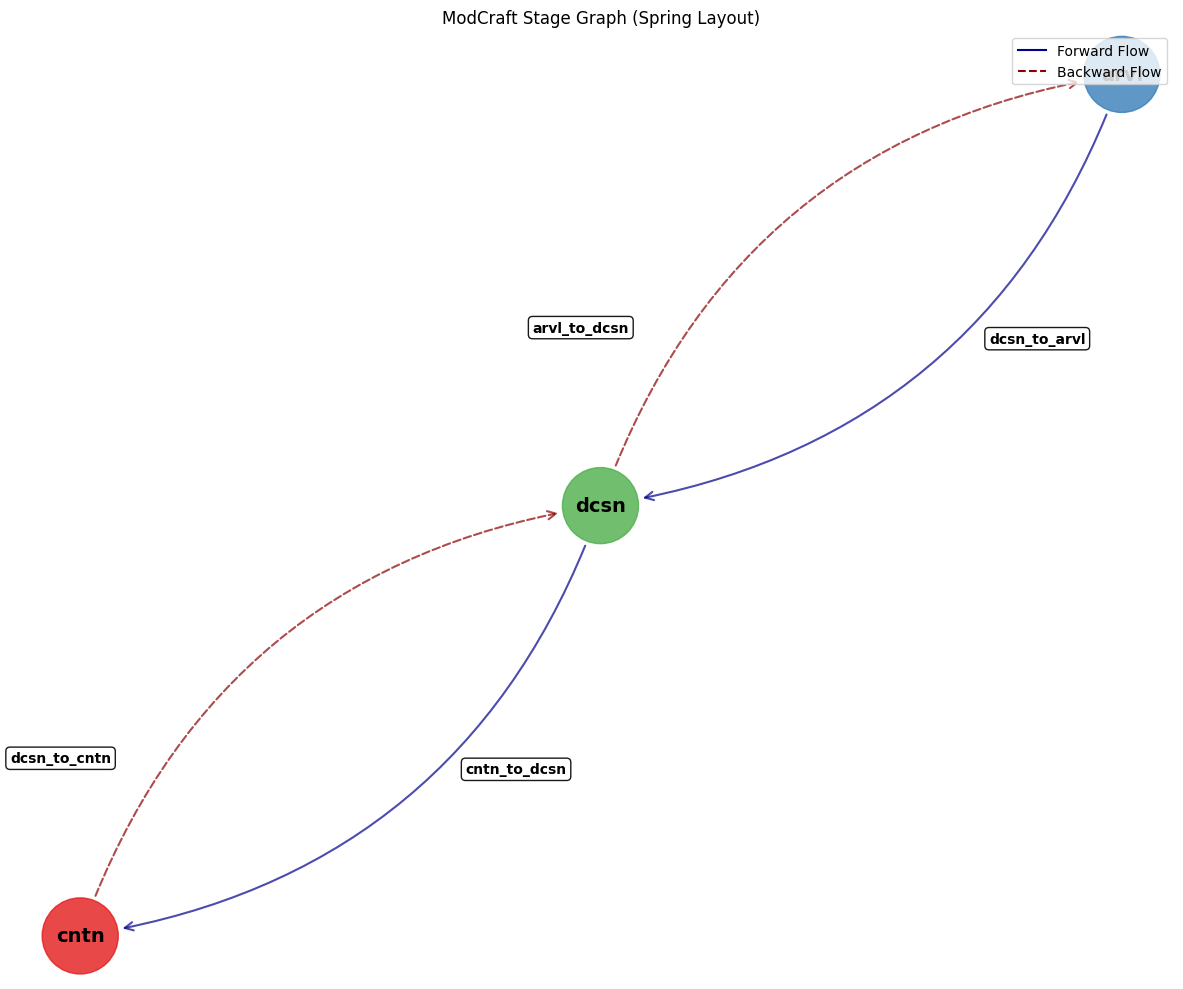

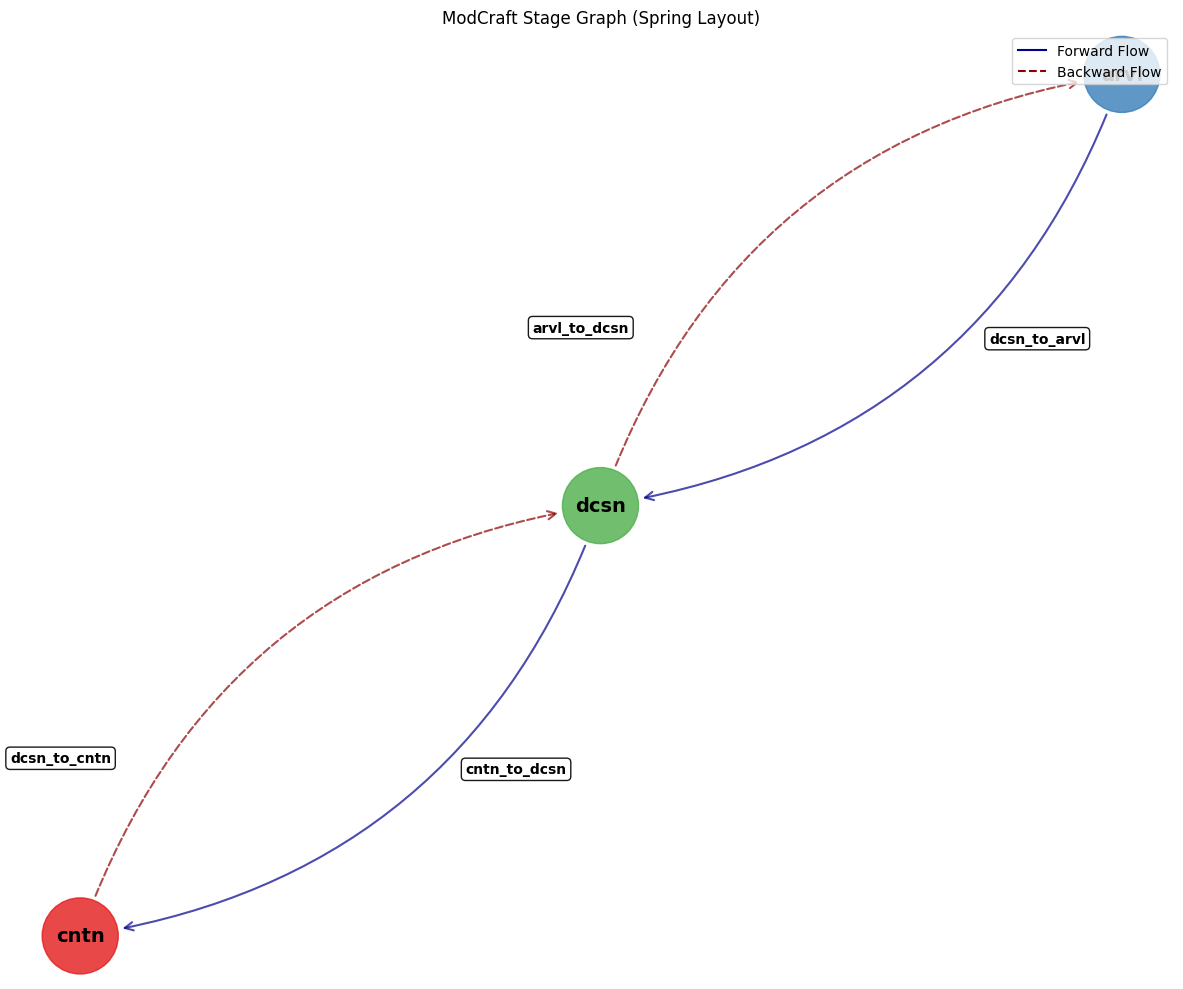

In [18]:
print("Stage graph structure:")
print(stage.graph)

# Print the nodes (perches) in the graph
print("\nGraph nodes (perches):")
print(stage.graph.nodes())

# Print the edges (movers) in the graph
print("\nGraph edges (movers):")
print(stage.graph.edges())
print(f"Current working directory: {os.getcwd()}")
from visualize_stage_graph import visualize_stage_graph
# Visualize the graph using the Stage's built-in method
print("\nVisualizing the stage graph:")
node_colors = {
       'arvl': '#377eb8',    # Blue
       'dcsn': '#4daf4a',    # Green
       'cntn': '#e41a1c'     # Red
   }
   
# Define custom edge styles
edge_styles = {
    'forward': {'color': 'darkblue', 'style': 'solid', 'width': 1.5, 'alpha': 0.7},
    'backward': {'color': 'darkred', 'style': 'dashed', 'width': 1.5, 'alpha': 0.7}
}

# Call with custom styling
visualize_stage_graph(
    stage,
    node_color_mapping=node_colors,
    edge_style_mapping=edge_styles,
    figsize=(12, 10),          # Larger figure size
    legend_loc='upper right'   # Move legend to upper right
)